# Chest X-Ray Medical Diagnosis with Deep Learning

In [60]:
# !pip install q keras==2.4.3

# %tensorflow_version 1.14.0


In [61]:
# from google.colab import drive
# drive.mount('/content/drive')

<img src="xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">


 We will explore medical image diagnosis by building a state-of-the-art chest X-ray classifier using Keras. 
In particular, we will:
- Pre-process and prepare a real-world X-ray dataset
- Use transfer learning to retrain a DenseNet model for X-ray image classification
- Learn a technique to handle class imbalance
- Measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve
- Visualize model activity using GradCAMs

 We will discuss in details about the following topics: 

- Data preparation
  - Visualizing data
  - Preventing data leakage
- Model Development
  - Addressing class imbalance
  - Leveraging pre-trained models using transfer learning
- Evaluation
  - AUC and ROC curves

## Outline
Use these links to jump to specific sections of this assignment!

- [1. Import Packages and Function](#1)
- [2. Load the Datasets](#2)
    - [2.1 Preventing Data Leakage](#2-1)
        - [Exercise 1 - Checking Data Leakage](#Ex-1)
    - [2.2 Preparing Images](#2-2)
- [3. Model Development](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
        - [Exercise 2 - Computing Class Frequencies](#Ex-2)
        - [Exercise 3 - Weighted Loss](#Ex-3)
    - [3.3 DenseNet121](#3-3)
- [4. Training [optional]](#4)
    - [4.1 Training on the Larger Dataset](#4-1)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)
    - [5.2 Visualizing Learning with GradCAM](#5-2)

<a name='1'></a>
## 1. Import Packages and Functions¶

We'll make use of the following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
- `util` will provide the locally defined utility functions that have been provided for this assignment

We will also use several modules from the `keras` framework for building deep learning models.

Run the next cell to import all the necessary packages.

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

<a name='2'></a>
## 2 Load the Datasets

 We will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
We can download the entire dataset for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). 

- These can be accessed in the folder path stored in the `IMAGE_DIR` variable.

The dataset includes a CSV file that provides the labels for each X-ray. 

 

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

#### Read in the data
Let's open these files using the [pandas](https://pandas.pydata.org/) library

In [63]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("mimic_train.csv")
valid_df = pd.read_csv("mimic_valid.csv")

In [64]:

test_df = pd.read_csv("mimic_test.csv")

train_df.head()

,dicon_id,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,Image
0,f53a5e74-a2b4b709-429330c4-98b39c6c-288bdf85,13899090,52105870,0,0,0,0,0,0,0,0,1,0,0,0,0,0,p13/p13899090/s52105870/f53a5e74-a2b4b709-4293...
1,39418729-478127df-0904e843-bdf9031b-4686f2af,15730635,53215349,1,0,1,1,0,0,0,0,0,1,0,0,0,0,p15/p15730635/s53215349/39418729-478127df-0904...
2,b5043994-86f1551d-37377961-5cb9f2c5-66c217e5,16076346,51034024,0,0,0,0,0,1,0,0,0,0,0,0,0,0,p16/p16076346/s51034024/b5043994-86f1551d-3737...
3,2b9616ae-7d8f437a-828a4bd1-fbdec9be-1bde8473,17496927,53222773,0,0,0,0,0,0,0,1,0,0,0,0,0,1,p17/p17496927/s53222773/2b9616ae-7d8f437a-828a...
4,376e8b3e-9cdaa906-a113d31b-82fed6f0-7ff02e03,10232455,54814158,0,1,0,0,0,0,0,0,0,0,0,0,0,0,p10/p10232455/s54814158/376e8b3e-9cdaa906-a113...


In [65]:
labels =  ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
             'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
             'No Finding', 'Pleural Other', 'Pleural Effusion',
             'Pneumonia', 'Pneumothorax', 'Support Devices']

<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

<a name='Ex-1'></a>
### Task 1 - Checking Data Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [66]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len( patients_in_both_groups)>0 # boolean (true if there is at least 1 patient in both groups)
    

    
    return leakage

In [67]:
# test
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")
print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


##### Expected output

```Python
test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False
```

Run the next cell to check if there are patients in both train and test or in both valid and test.

In [68]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'study_id')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'study_id')))

leakage between train and test: True
leakage between valid and test: True


If we get `False` for both, then we're ready to start preparing the datasets for training. 

<a name='2-2'></a>
### 2.2 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be 320px by 320px

In [69]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1, target_w = 320, target_h = 320):
  
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data. 

** We use the same generator as for the training data**


- It normalizes each image **per batch**, meaning that it uses batch statistics. 
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage.  
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**. 
* We implement this in the function below. 
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. 
* However, since this is extremely large, that would be very time consuming. 
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [72]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=16, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    test_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator, valid_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [73]:
IMAGE_DIR = "mimic_cxr/images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 105723 validated image filenames.
getting train and valid generators...
Found 105723 validated image filenames.
Found 26431 validated image filenames.
Found 1824 validated image filenames.


In [74]:
len(test_generator.filenames)

1824

Let's check  what the generator gives our model during training and validation. We can do this by calling the `__get_item__(index)` function:

In [75]:
print("\nTest Generator Info:")
print(f"Batch size: {test_generator.batch_size}")
print(f"Number of batches: {len(test_generator)}")
print(f"Total samples: {len(test_generator) * test_generator.batch_size}")


Test Generator Info:
Batch size: 16
Number of batches: 114
Total samples: 1824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


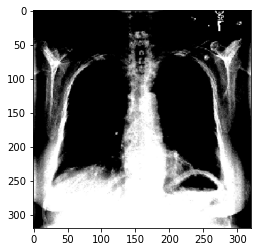

In [76]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch filenames and study IDs:
Image 0: p14/p14786549/s59546576/fd1a395b-3e8de1ee-eb4cb018-c05c0347-875d0edd.jpg -> Study ID: 59546576


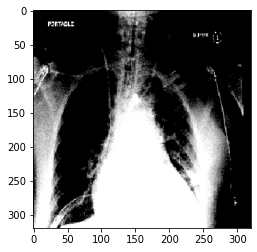

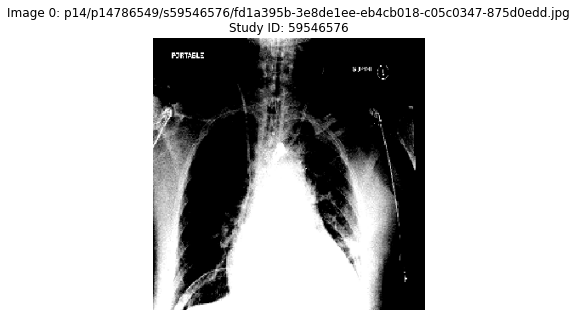

Image 1: p14/p14866589/s54833144/dbf94652-7e6d26e3-1c222e5a-796eaa6e-553a66ec.jpg -> Study ID: 54833144
Image 2: p13/p13474473/s56969897/11164f42-13c77949-b381a3a8-926d4bc1-484e137f.jpg -> Study ID: 56969897
Image 3: p17/p17135687/s56078872/fdea417d-cf04bcf1-3d0d0dac-9531cf86-f6fa828e.jpg -> Study ID: 56078872
Image 4: p10/p10614767/s53439117/ff57ef42-843bc4a2-0d9bfc71-5effef36-fd03f6a6.jpg -> Study ID: 53439117
Image 5: p16/p16458160/s52002237/74c8f391-02ab9065-22d10cf6-e2ccaaf9-1a714acb.jpg -> Study ID: 52002237
Image 6: p18/p18753961/s58735998/3a605820-25f69b7a-b39d5ebe-8bfe250e-9f0e1492.jpg -> Study ID: 58735998
Image 7: p11/p11055512/s51743744/82a1c74c-6300c801-43131fcf-82ff9ea0-036f2ac2.jpg -> Study ID: 51743744
Image 8: p12/p12683111/s58787340/c0a0608f-5eccaee0-1275d655-5cd9a3d4-2acad67a.jpg -> Study ID: 58787340
Image 9: p19/p19377528/s55309837/f8fd0a09-41d28213-5ee98961-69316283-f33c02c9.jpg -> Study ID: 55309837
Image 10: p13/p13875890/s59846277/8d9d72dc-8a9733f5-5a408a79-fb1

In [77]:
x, y = valid_generator.__getitem__(0)
plt.imshow(x[0]);
# Check filenames in the valid generator
if hasattr(valid_generator, 'filenames'):
    # Get the indices of the current batch
    batch_idx = 0  # Your current batch index
    start_idx = batch_idx * valid_generator.batch_size
    end_idx = start_idx + valid_generator.batch_size
    
    # Get filenames for this batch
    batch_filenames = valid_generator.filenames[start_idx:end_idx]
    
    # Display filenames and extract study_ids
    print("Batch filenames and study IDs:")
    for i, filename in enumerate(batch_filenames):
        # Extract study_id using regex
        import re
        study_id_match = re.search(r's(\d+)', filename)
        study_id = study_id_match.group(1) if study_id_match else "Unknown"
        
        print(f"Image {i}: {filename} -> Study ID: {study_id}")
        
        # Display the first image for verification
        if i == 0:
            plt.figure(figsize=(10, 5))
            plt.imshow(x[i])
            plt.title(f"Image 0: {filename}\nStudy ID: {study_id}")
            plt.axis('off')
            plt.show()
else:
    print("valid generator does not have filenames attribute")

# Alternative approach - check index mapping if generator uses it
if hasattr(valid_generator, 'index_array') and hasattr(valid_generator, 'filenames'):
    batch_indices = valid_generator.index_array[0:valid_generator.batch_size]
    print("\nBatch indices:")
    print(batch_indices)
    
    print("\nCorresponding filenames:")
    for idx in batch_indices:
        if idx < len(valid_generator.filenames):
            print(f"Index {idx}: {valid_generator.filenames[idx]}")

<a name='3'></a>
## 3 Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

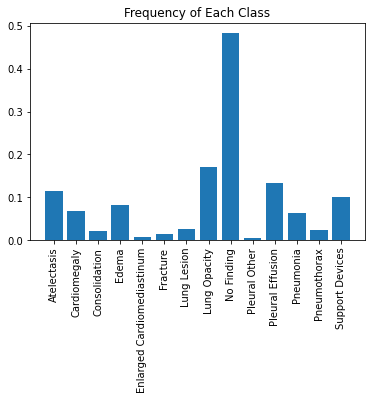

In [78]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='Ex-2'></a>
### Task 2 - Computing Class Frequencies
 Calculation of the frequences for each label in our dataset.

In [79]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
   
    
    # total number of patients (rows)
    N = len(labels)
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = 1-positive_frequencies

    
    return positive_frequencies, negative_frequencies

In [80]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


##### Expected output

```Python
labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]
```

Now we'll compute frequencies for our training data.

In [81]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.1148    , 0.06885919, 0.02221844, 0.08304721, 0.00903304,
       0.01512443, 0.02594516, 0.17170341, 0.48200486, 0.00482393,
       0.13312146, 0.06374204, 0.02413855, 0.10154839])

Let's visualize these two contribution ratios next to each other for each of the pathologies:

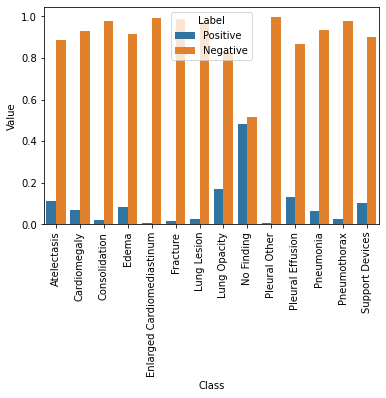

In [82]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [83]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other again:

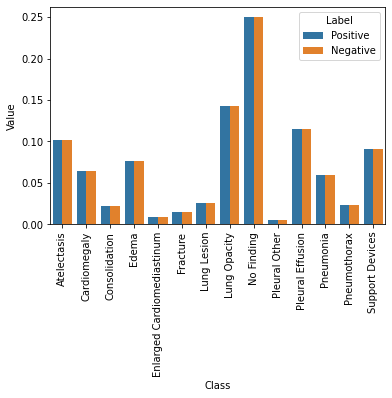

In [84]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
### Task 3 - Weighted Loss
The `weighted_loss` function below returns a loss function that calculates the weighted loss for each batch. For the multi-class loss, we add up the average loss for each individual class. We also add a small value, $\epsilon$, to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.




In [85]:

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
            -1 * np.sum(w_p[0] * 
                y_true[:, 0] * 
                np.log(y_pred[:, 0])
              )
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -1 * K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon)) + -1 * K.mean(neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))  #complete this line
        return loss
    
    
    return weighted_loss

Now let's test our function with some simple cases. 

In [86]:
# Test
sess = K.get_session()
with sess.as_default() as sess:
    print("Test example:\n")
    y_true = K.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]
    ))
    print("y_true:\n")
    print(y_true.eval())

    w_p = np.array([0.25, 0.25, 0.5])
    w_n = np.array([0.75, 0.75, 0.5])
    print("\nw_p:\n")
    print(w_p)

    print("\nw_n:\n")
    print(w_n)

    y_pred_1 = K.constant(0.7*np.ones(y_true.shape))
    print("\ny_pred_1:\n")
    print(y_pred_1.eval())

    y_pred_2 = K.constant(0.3*np.ones(y_true.shape))
    print("\ny_pred_2:\n")
    print(y_pred_2.eval())

    # test with a large epsilon in order to catch errors
    L = get_weighted_loss(w_p, w_n, epsilon=1)

    print("\nIf we weighted them correctly, we expect the two losses to be the same.")
    L1 = L(y_true, y_pred_1).eval()
    L2 = L(y_true, y_pred_2).eval()
    print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
    print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:

[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:

[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If we weighted them correctly, we expect the two losses to be the same.

L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
Difference is L1 - L2 = 0.0000


#### Additional check
If we implemented the function correctly, then if the epsilon for the `get_weighted_loss` is set to `1`, the weighted losses will be as follows:
```Python
L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
```
If we are missing something in your implementation, we will see a different set of losses for L1 and L2 (even though L1 and L2 will be the same).

<a name='3-3'></a>
### 3.3 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [87]:
from keras.optimizers import SGD
from keras.metrics import *
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]      

# create the base pre-trained model
base_model = DenseNet121(weights=None, include_top=False)

# Load weights manually
base_model.load_weights('densenet.hdf5')


x =  base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)


# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

optimizer = SGD(learning_rate=0.001,momentum=0.9,nesterov=False)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss=get_weighted_loss(pos_weights, neg_weights),metrics=METRICS)
  



<a name='4'></a>
## 4 Training 

With our model ready for training, we will use the `model.fit()` function in Keras to train our model. 
- We are training on a small subset of the dataset (~1%).  
- So what we care about at this point is to make sure that the loss on the training set is decreasing.

Since training can take a considerable time, for pedagogical purposes we have chosen not to train the model here but rather to load a set of pre-trained weights in the next section. However, we can use the code shown below to practice training the model locally on our machine or in Colab.



Python Code for training the model:

```python
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()
```

In [88]:
# !pip install pyyaml h5py
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Epoch 1/100
100/100 [==============================] - 1730s 17s/step - loss: 1.3251 - tp: 1285.0000 - fp: 9346.0000 - tn: 10960.0000 - fn: 809.0000 - accuracy: 0.5467 - precision: 0.1209 - recall: 0.6137 - auc: 0.6107 - val_loss: 1.6558 - val_tp: 232.0000 - val_fp: 1109.0000 - val_tn: 3964.0000 - val_fn: 295.0000 - val_accuracy: 0.7493 - val_precision: 0.1730 - val_recall: 0.4402 - val_auc: 0.6621
Epoch 2/100
100/100 [==============================] - 1511s 15s/step - loss: 1.2216 - tp: 1378.0000 - fp: 7902.0000 - tn: 12432.0000 - fn: 688.0000 - accuracy: 0.6165 - precision: 0.1485 - recall: 0.6670 - auc: 0.6986 - val_loss: 1.2506 - val_tp: 309.0000 - val_fp: 1186.0000 - val_tn: 3894.0000 - val_fn: 211.0000 - val_accuracy: 0.7505 - val_precision: 0.2067 - val_recall: 0.5942 - val_auc: 0.7558
Epoch 3/100
100/100 [==============================] - 1482s 15s/step - loss: 1.1932 - tp: 1492.0000 - fp: 7555.0000 - tn: 12708.0000 - fn: 645.0000 - accuracy: 0.6339 - precision: 0.1649 - recall

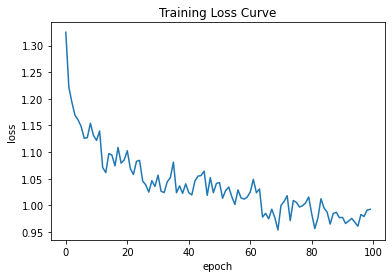

In [89]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 100)
 
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

model.save('my_model.hdf5')
model.save('my_model.h5')

In [99]:
model.save_weights('my_model_weights.h5')

model_json = model.to_json()
with open('my_model_config.json', 'w') as json_file:
    json_file.write(model_json)

print("Model saved successfully in multiple formats")

Model saved successfully in multiple formats


In [100]:
# Check if generator is using the correct files from test_df
def compare_generator_with_df(generator, df, image_col="Image"):
    """
    Compare files in generator with files in DataFrame
    
    Args:
        generator: Keras data generator
        df: DataFrame with image filenames
        image_col: Column name containing image filenames
    
    Returns:
        Match statistics
    """
    # Get filenames from generator
    if not hasattr(generator, 'filenames'):
        return "Generator doesn't have filenames attribute"
    
    generator_files = set(generator.filenames)
    
    # Get filenames from DataFrame
    if image_col not in df.columns:
        return f"No column named '{image_col}' in DataFrame"
    
    df_files = set(df[image_col].values)
    
    # Compare sets
    common_files = generator_files.intersection(df_files)
    only_in_generator = generator_files - df_files
    only_in_df = df_files - generator_files
    
    # Return statistics
    results = {
        'files_in_generator': len(generator_files),
        'files_in_df': len(df_files),
        'files_in_both': len(common_files),
        'files_only_in_generator': len(only_in_generator),
        'files_only_in_df': len(only_in_df),
        'match_percentage': len(common_files) / len(df_files) * 100 if len(df_files) > 0 else 0
    }
    
    return results

# Check both generators against their expected DataFrames
valid_comparison = compare_generator_with_df(valid_generator, valid_df)
test_comparison = compare_generator_with_df(test_generator, test_df)

print("Validation generator vs valid_df:")
for key, value in valid_comparison.items():
    print(f"  {key}: {value}")

print("\nTest generator vs test_df:")
for key, value in test_comparison.items():
    print(f"  {key}: {value}")

# If there's a mismatch, show some examples
if isinstance(valid_comparison, dict) and valid_comparison['match_percentage'] < 100:
    print("\nSample filenames in validation generator:")
    for filename in list(test_generator.filenames)[:5]:
        print(f"  {filename}")
    
    print("\nSample filenames in valid_df:")
    for filename in valid_df['Image'].values[:5]:
        print(f"  {filename}")

if isinstance(test_comparison, dict) and test_comparison['match_percentage'] < 100:
    print("\nSample filenames in test generator:")
    for filename in list(valid_generator.filenames)[:5]:
        print(f"  {filename}")
    
    print("\nSample filenames in test_df:")
    for filename in test_df['Image'].values[:5]:
        print(f"  {filename}")

Validation generator vs valid_df:
  files_in_generator: 26431
  files_in_df: 26431
  files_in_both: 26431
  files_only_in_generator: 0
  files_only_in_df: 0
  match_percentage: 100.0

Test generator vs test_df:
  files_in_generator: 1824
  files_in_df: 1824
  files_in_both: 1824
  files_only_in_generator: 0
  files_only_in_df: 0
  match_percentage: 100.0


In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [102]:
len(test_generator.filenames)

1824

In [104]:
# Define a function to process predictions
def generate_pathology_report(predicted_vals, labels):

    all_predictions = []
    
    # Process each image prediction
    for i in range(len(predicted_vals)):
        # Get predictions for this image
        prediction = predicted_vals[i]
        
        # Create dictionary mapping pathology names to probabilities
        pathology_probs = {label: float(prob) for label, prob in zip(labels, prediction)}
        
        # Sort by probability (highest first)
        sorted_probs = dict(sorted(pathology_probs.items(), key=lambda x: x[1], reverse=True))
        
        all_predictions.append(pathology_probs)
    
    return all_predictions

# Get test image filenames
test_filenames = test_generator.filenames if hasattr(test_generator, 'filenames') else None

# Generate pathology reports
pathology_reports = generate_pathology_report(predicted_vals, labels)

# Display the predictions for the first 5 images
for i, report in enumerate(pathology_reports[:5]):
    print(f"\nImage {i+1}:")
    print("-" * 40)
    
    if test_filenames:
        print(f"Filename: {test_filenames[i]}")
    
    print("Pathology Predictions:")
    for pathology, probability in report.items():
        # Only show probabilities above a threshold (e.g., 1%)
        if probability > 0.01:
            print(f"{pathology}: {probability:.4f}")


Image 1:
----------------------------------------
Filename: p19/p19061282/s50010466/144f46e1-630ba5e3-82d84674-9f0575c5-6017bdd1.jpg
Pathology Predictions:
Atelectasis: 0.2659
Cardiomegaly: 0.4719
Consolidation: 0.2951
Edema: 0.1105
Enlarged Cardiomediastinum: 0.5096
Fracture: 0.4287
Lung Lesion: 0.4626
Lung Opacity: 0.5635
No Finding: 0.5209
Pleural Other: 0.3183
Pleural Effusion: 0.1178
Pneumonia: 0.5208
Pneumothorax: 0.2437
Support Devices: 0.3659

Image 2:
----------------------------------------
Filename: p18/p18835687/s50014127/73da0836-553a87de-58ef0562-f9c31de6-c47927ac.jpg
Pathology Predictions:
Atelectasis: 0.3400
Cardiomegaly: 0.1577
Consolidation: 0.2269
Edema: 0.0953
Enlarged Cardiomediastinum: 0.7545
Fracture: 0.4283
Lung Lesion: 0.3943
Lung Opacity: 0.5271
No Finding: 0.6307
Pleural Other: 0.2017
Pleural Effusion: 0.0680
Pneumonia: 0.3033
Pneumothorax: 0.5240
Support Devices: 0.5955

Image 3:
----------------------------------------
Filename: p15/p15131736/s50016102/b57

In [95]:
len(pathology_reports)

1824

In [105]:
# Get true labels from test generator
y_true = np.vstack([test_generator[i][1] for i in range(len(test_generator))])

# Get test image filenames
test_filenames = test_generator.filenames if hasattr(test_generator, 'filenames') else None

# Display predictions and true labels for the first 5 images
for i in range(5):  # Show first 5 images
    print(f"\nImage {i+1}:")
    print("-" * 50)
    
    if test_filenames:
        print(f"Filename: {test_filenames[i]}")
    
    print("\nTrue Labels:")
    for j, label in enumerate(labels):
        if y_true[i][j] == 1:
            print(f"- {label}")
    
    print("\nPredicted Probabilities:")
    # Sort predictions by probability (highest first)
    predictions = [(label, float(predicted_vals[i][j])) for j, label in enumerate(labels)]
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    
    # Print top predictions (with probability > 1%)
    for label, prob in sorted_predictions:
        if prob > 0.01:
            print(f"- {label}: {prob:.4f}")


Image 1:
--------------------------------------------------
Filename: p19/p19061282/s50010466/144f46e1-630ba5e3-82d84674-9f0575c5-6017bdd1.jpg

True Labels:
- No Finding

Predicted Probabilities:
- Lung Opacity: 0.5635
- No Finding: 0.5209
- Pneumonia: 0.5208
- Enlarged Cardiomediastinum: 0.5096
- Cardiomegaly: 0.4719
- Lung Lesion: 0.4626
- Fracture: 0.4287
- Support Devices: 0.3659
- Pleural Other: 0.3183
- Consolidation: 0.2951
- Atelectasis: 0.2659
- Pneumothorax: 0.2437
- Pleural Effusion: 0.1178
- Edema: 0.1105

Image 2:
--------------------------------------------------
Filename: p18/p18835687/s50014127/73da0836-553a87de-58ef0562-f9c31de6-c47927ac.jpg

True Labels:
- Lung Opacity

Predicted Probabilities:
- Enlarged Cardiomediastinum: 0.7545
- No Finding: 0.6307
- Support Devices: 0.5955
- Lung Opacity: 0.5271
- Pneumothorax: 0.5240
- Fracture: 0.4283
- Lung Lesion: 0.3943
- Atelectasis: 0.3400
- Pneumonia: 0.3033
- Consolidation: 0.2269
- Pleural Other: 0.2017
- Cardiomegaly: 

In [106]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model_performance(predicted_vals, test_generator, labels):
    # Extract the true labels from test generator
    y_true = np.vstack([test_generator[i][1] for i in range(len(test_generator))])
    
    # Convert predictions to binary (0/1) using 0.5 threshold
    y_pred_binary = (predicted_vals >= 0.5).astype(int)
    
    # Store metrics for each pathology
    results = {}
    
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    results['overall_accuracy'] = overall_accuracy
    
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print("\nPathology-specific metrics:")
    print("=" * 60)
    print(f"{'Pathology':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
    print("-" * 60)
    
    # Calculate metrics for each pathology
    for i, label in enumerate(labels):
        # Extract true and predicted values for this pathology
        true_label = y_true[:, i]
        pred_prob = predicted_vals[:, i]
        pred_binary = y_pred_binary[:, i]
        
        # Calculate metrics
        accuracy = accuracy_score(true_label, pred_binary)
        precision = precision_score(true_label, pred_binary, zero_division=0)
        recall = recall_score(true_label, pred_binary, zero_division=0)
        f1 = f1_score(true_label, pred_binary, zero_division=0)
        
        # Calculate AUC only if there are both positive and negative samples
        if len(np.unique(true_label)) > 1:
            auc = roc_auc_score(true_label, pred_prob)
        else:
            auc = float('nan')
        
        # Store results
        results[label] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
        
        # Print results
        print(f"{label:<25} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {auc:<10.4f}")
    
    return results

# Evaluate model performance
performance_metrics = evaluate_model_performance(predicted_vals, test_generator, labels)

Overall Accuracy: 0.6002

Pathology-specific metrics:
Pathology                 Accuracy   Precision  Recall     F1         AUC       
------------------------------------------------------------
Atelectasis               0.6924     0.2575     0.6508     0.3690     0.7479    
Cardiomegaly              0.5636     0.2024     0.9615     0.3344     0.8488    
Consolidation             0.5444     0.0709     0.7750     0.1298     0.7198    
Edema                     0.7023     0.3747     0.9284     0.5339     0.8863    
Enlarged Cardiomediastinum 0.1157     0.0141     1.0000     0.0277     0.7587    
Fracture                  0.7023     0.0330     0.5294     0.0622     0.6087    
Lung Lesion               0.6831     0.0634     0.5441     0.1135     0.6865    
Lung Opacity              0.4945     0.3170     0.8736     0.4652     0.7047    
No Finding                0.7812     0.6111     0.5333     0.5696     0.8058    
Pleural Other             0.5071     0.0303     0.8750     0.0586     0.74

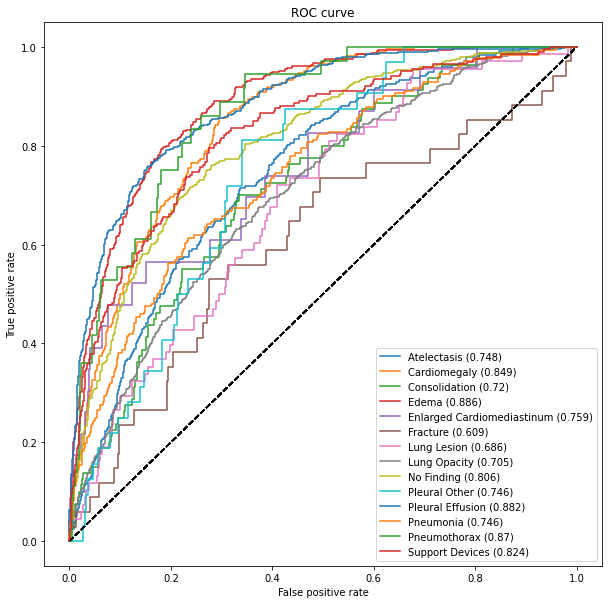

In [107]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [108]:
#df = pd.read_csv("preprocessed_dataset/train-small.csv")
#IMAGE_DIR = "preprocessed_dataset/images-small/"

# only show the labels with top 4 AUC
#labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Now let's look at a few specific images.

In [109]:
#util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

In [110]:
#util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

In [111]:
#util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

In [112]:
#util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

In [113]:
test_df

,dicon_id,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,Image
0,144f46e1-630ba5e3-82d84674-9f0575c5-6017bdd1,19061282,50010466,0,0,0,0,0,0,0,0,1,0,0,0,0,0,p19/p19061282/s50010466/144f46e1-630ba5e3-82d8...
1,73da0836-553a87de-58ef0562-f9c31de6-c47927ac,18835687,50014127,0,0,0,0,0,0,0,1,0,0,0,0,0,0,p18/p18835687/s50014127/73da0836-553a87de-58ef...
2,b57face8-df2c3c57-2a99e6b1-4919f774-c8c3e93c,15131736,50016102,0,1,0,1,0,0,0,0,0,0,0,0,0,0,p15/p15131736/s50016102/b57face8-df2c3c57-2a99...
3,1908e913-d3051cf7-34f98451-4ed66f58-15582c1d,13881772,50019396,0,0,0,0,0,0,0,0,0,1,0,0,0,0,p13/p13881772/s50019396/1908e913-d3051cf7-34f9...
4,a767b7c0-6bdaee42-8ca0cd60-7b89ffb1-3bbbba27,15758946,50020371,0,0,0,0,0,0,0,0,1,0,0,0,0,0,p15/p15758946/s50020371/a767b7c0-6bdaee42-8ca0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,3470d736-53ab4170-ab83b760-57a5b839-c7302405,11212873,59983953,1,0,0,0,0,0,0,0,0,0,0,0,0,1,p11/p11212873/s59983953/3470d736-53ab4170-ab83...
1820,87f64c4d-93ab83e7-04f10c4b-a9ed71f7-d05889f2,19759491,59984376,0,0,0,1,0,0,0,0,0,1,0,1,0,0,p19/p19759491/s59984376/87f64c4d-93ab83e7-04f1...
1821,417d5c5e-b521f965-35306684-68e7deb2-cda06f5c,12369221,59986698,0,0,0,0,0,0,0,0,1,0,0,0,0,0,p12/p12369221/s59986698/417d5c5e-b521f965-3530...
1822,2d5f73c2-9a6138e2-d33b6539-067b7734-2b55b088,15370732,59990602,0,0,0,0,0,0,0,0,1,0,0,0,0,0,p15/p15370732/s59990602/2d5f73c2-9a6138e2-d33b...


In [114]:

labels_df = pd.read_csv("mimic-cxr-2.0.0-chexpert.csv")

labels_df['study_id'] = labels_df['study_id'].astype(str)
labels_df

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [115]:
import pandas as pd

# Define the specific order for pathologies
ordered_pathologies = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
    'No Finding', 'Pleural Other', 'Pleural Effusion',
    'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# Create empty DataFrame with desired columns
results_df = pd.DataFrame(columns=['subject_id', 'study_id', 'classification_result'])

# Process each prediction
for i, report in enumerate(pathology_reports):
    # Skip if we don't have filenames or we're past the available filenames
    if not test_filenames or i >= len(test_filenames):
        continue
        
    # Extract filename
    filename = test_filenames[i]
    
    # Extract study_id from filename
    import re
    study_id_match = re.search(r's(\d+)', filename)
    if not study_id_match:
        continue
        
    study_id = study_id_match.group(1)
    
    # Find corresponding subject_id in labels_df
    match = labels_df[labels_df['study_id'] == study_id]
    if len(match) == 0:
        continue
        
    subject_id = str(match.iloc[0]['subject_id'])
    
    # Create an ordered classification result
    ordered_result = []
    
    # Add pathologies in the specified order
    for pathology in ordered_pathologies:
        if pathology in report:
            prob = report[pathology]
            prob_str = f"{prob:.4f}"
            ordered_result.append((pathology, prob_str))
    
    # Add to results DataFrame
    new_row = {
        'subject_id': subject_id,
        'study_id': study_id,
        'classification_result': str(ordered_result)
    }
    results_df = results_df.append(new_row, ignore_index=True)


In [116]:
results_df.to_csv('predictions.csv', index=False)

# Print first few rows
print(results_df.head())

  subject_id  study_id                              classification_result
0   19061282  50010466  [('Atelectasis', '0.2659'), ('Cardiomegaly', '...
1   18835687  50014127  [('Atelectasis', '0.3400'), ('Cardiomegaly', '...
2   15131736  50016102  [('Atelectasis', '0.5137'), ('Cardiomegaly', '...
3   13881772  50019396  [('Atelectasis', '0.7200'), ('Cardiomegaly', '...
4   15758946  50020371  [('Atelectasis', '0.3045'), ('Cardiomegaly', '...
